<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Fine_Tuning_for_Llama2_7b_on_a_Single_GPU_using_Ludwig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Goal: Use LLMs For Code-Generation** 💻

As an example, if we prompt the model with this instruction:

```
Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
```

We want the model to produce exactly this response:

```
Response: array = [2, 4, 6, 8, 10]
```



### **Install Ludwig and Ludwig's LLM related dependencies.**

Install Ludwig from the latest release

In [1]:
# !pip install ludwig
# !pip install ludwig[llm]

Install Ludwig from Ludwig master

In [3]:
!pip uninstall -y tensorflow --quiet
!pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
!pip install "git+https://github.com/ludwig-ai/ludwig.git@master#egg=ludwig[llm]" --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 13.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━

Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [4]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    model = None
    torch.cuda.empty_cache()

### **Setup Your HuggingFace Token** 🤗

We'll be exploring Llama-2 today, which a model released by Meta. However, the model is not openly-accessible and requires requesting for access (assigned to your HuggingFace token).

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) and request access to [Llama2-7b-hf](https://huggingface.co/meta-llama/Llama-2-7b-hf) before proceeding. You may need to signup on HuggingFace if you don't aleady have an account: https://huggingface.co/join

Incase you haven't been given access to Llama-2-7b, that is alright. We can just use Llama-1 for the rest of this example: [huggyllama/llama-7b](https://huggingface.co/huggyllama/llama-7b).

In [5]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


### **Import The Code Generation Dataset** 📋



In [6]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json("https://raw.githubusercontent.com/sahil280114/codealpaca/master/data/code_alpaca_20k.json")

# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# For this webinar, we will just 100 rows of this dataset.
df = df.head(n=100)

## **Understanding The Code Alpaca Dataset** 📖




In [7]:
df.head(10)

,instruction,input,output,split
0,Create an array of length 5 which contains all...,,"arr = [2, 4, 6, 8, 10]",0
1,Formulate an equation to calculate the height ...,,Height of triangle = opposite side length * si...,0
2,Write a replace method for a string class whic...,"string = ""Hello World!""\nreplace_with = ""Greet...","def replace(self, replace_with):\n new_stri...",0
3,Create an array of length 15 containing number...,,"arr = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33...",0
4,Write a function to find the number of distinc...,"matrix = [[1, 0, 0],\n [1, 0, 1],\n ...",def find_num_distinct_states(matrix):\n sta...,0
5,Create a nested loop to print every combinatio...,,for i in range(10):\n for j in range(10):\n...,0
6,Write a function to find the maximum differenc...,"arr = [5, 3, 17, 11, 9]",def max_difference(arr):\n max_diff = 0\n ...,0
7,Write a function to generate the nth Fibonacci...,< noinput >,def fib(n):\n if n == 0:\n return 0\...,0
8,Write a class to represent a 2D point with x a...,,"class Point:\n def __init__(self, x, y):\n ...",0
9,Write code that removes spaces from a given st...,"string = "" A B C D ""","def remove_spaces(string): \n return """".joi...",0


As you can see below, the dataset is pretty balanced in terms of the number of examples of each type of instruction (also true for the full dataset with 20,000 rows).

In [8]:
num_self_sufficient = (df['input'] == '').sum()
num_need_contex = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_contex/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 100
% of examples that are self-sufficient: 49.0
% of examples that are need additional context: 51.0


The other aspect worth noting is the average number of characters in each of the three columns `instruction`, `input` and `output` in the dataset. Typically, every 3-4 characters maps to a *token* (the basic building blocks that language models use to understand and analyze text data), and large language models have a limit on the number of tokens they can take as input.

The maximum context length for the base LLaMA-2 model is 4096 tokens. Ludwig automatically truncates texts that are too long for the model, but looking at these sequence lengths, we should be able to fine-tune on full length examples without needing any truncation.





Average number of tokens in the instruction column: 23
Average number of tokens in the input column: 8
Average number of tokens in the output column: 65



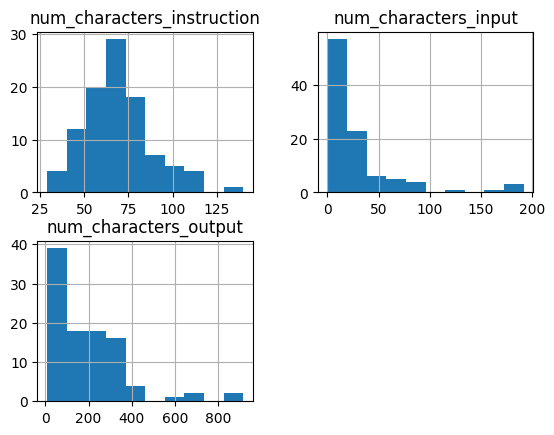

In [ ]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

In [9]:
zero_shot_config = yaml.safe_load(
  """
  model_type: llm
  base_model: meta-llama/Llama-2-7b-hf

  input_features:
    - name: instruction
      type: text

  output_features:
    - name: output
      type: text

  prompt:
    template: >-
      Below is an instruction that describes a task, paired with an input
      that may provide further context. Write a response that appropriately
      completes the request.

      ### Instruction: {instruction}

      ### Input: {input}

      ### Response:

  generation:
    temperature: 0.1 # Temperature is used to control the randomness of predictions.
    max_new_tokens: 512

  preprocessing:
    split:
      type: fixed

  quantization:
    bits: 4
  """
)

# Just run on 10 examples for now
model = LudwigModel(config=zero_shot_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 152 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 154 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 154 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'output': 275 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 277 (including start and stop symbols)
INFO:ludwig.featur

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.trainers.trainer_llm:
Running evaluation for step: 0, epoch: 0


Evaluation valid:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a jsx code that renders a "hello, world!" message in the browser.
### input: 
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide 

Evaluation valid:  25%|██▌       | 1/4 [00:45<02:17, 45.94s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: generate a random number between 0 and 1 (inclusively).
### input: 
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: generate a random number between 0 and 1 (inclusively).
### input: 
### response: 
### instruction: generate a random number between 0 and 1 (inclusively).
### input: 
### response: 
### instruction: generate a random number between

Evaluation valid:  50%|█████     | 2/4 [01:26<01:25, 42.54s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a quick-sort algorithm in python.
### input: 
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a quick-sort algorithm in python.
### input: 
### response:
### instruction: create a quick-sort algorithm in python.
### input:
### response:
### instruction: create a quick-sort algorithm in python.
### input:
### response:
### instructio

Evaluation valid:  75%|███████▌  | 3/4 [02:07<00:41, 41.87s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: write a function that takes in a list of numbers and prints out the greatest number.
### input: list = [8, 2, 14, 25]
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: write a function that takes in a list of numbers and prints out the greatest number.
### input: list = [8, 2, 14, 25]
### response: 25
### instruction: write a function that takes in

Evaluation test :   0%|          | 0/8 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a c++ program for randomly shuffling an array of integers.
### input: 
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further

Evaluation test :  12%|█▎        | 1/8 [00:41<04:51, 41.69s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: remove the boilerplate code from the program for printing 10 random numbers.
### input: import random

# generate 10 random numbers
for i in range(10):
    # todo
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: remove the boilerplate code from the program for printing 10 random numbers.
### input: import random

# generate 10 random numbers
for i

Evaluation test :  25%|██▌       | 2/8 [01:22<04:06, 41.17s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: write an sql query to calculate the average order price for each product category in the "orders" table.
### input: 
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: write an sql query to calculate the average order price for each product category in the "orders" table.
### input: 
### response:
### instruction: write an sql query to calculate the

Evaluation test :  38%|███▊      | 3/8 [02:03<03:26, 41.32s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: change the variable `x` to the data type desired.
### input: x = 'hello world!'
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: change the variable `x` to the data type desired.
### input: x = 'hello world!'
### response: x = 'hello world!'
### instruction: change the variable `x` to the data type desired.
### input: x = 'hello world!'
### respon

Evaluation test :  50%|█████     | 4/8 [02:44<02:43, 40.98s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: is it possible to set a breakpoint that is not associated with any source code line in a gdb program?
### input: 
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: is it possible to set a breakpoint that is not associated with any source code line in a gdb program?
### input: 
### response:
### instruction: is it possible to set a breakpoint that i

Evaluation test :  62%|██████▎   | 5/8 [03:26<02:03, 41.21s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a table to store customer information.
### input: 
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: create a table to store customer information.
### input: 
### response: 
### instruction: create a table to store customer information.
### input: 
### response: 
### instruction: create a table to store customer information.
### input: 
### 

Evaluation test :  75%|███████▌  | 6/8 [04:06<01:21, 40.99s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: parse the string and return the number of unique alphabets in the string.
### input: stringinput = "apple"
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: parse the string and return the number of unique alphabets in the string.
### input: stringinput = "apple"
### response: 1
### instruction: parse the string and return the number of unique alph

Evaluation test :  88%|████████▊ | 7/8 [04:48<00:41, 41.15s/it]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: write a function to remove all whitespace characters from a given string.
### input: mystring = "hello   world    "
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that may provide further context. write a response that appropriately completes the request.
### instruction: write a function to remove all whitespace characters from a given string.
### input: mystring = "hello   world    "
### response: removeWhitespace(mystring) = "hello world"
### instruc

Evaluation test : 100%|██████████| 8/8 [05:28<00:00, 41.00s/it]

INFO:ludwig.trainers.trainer_llm:Evaluation took 8m 15.8914s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤═════════╤══════════════╤════════════╕
│                       │ train   │   validation │       test │
╞═══════════════════════╪═════════╪══════════════╪════════════╡
│ bleu                  │         │       0.0076 │     0.0102 │
├───────────────────────┼─────────┼──────────────┼────────────┤
│ char_error_rate       │         │       0.9907 │     0.9915 │
├───────────────────────┼─────────┼──────────────┼────────────┤
│ loss                  │         │      10.3735 │    10.3735 │
├───────────────────────┼─────────┼──────────────┼────────────┤
│ next_token_perplexity │         │   32000.0645 │ 32000.0645 │
├───────────────────────┼─────────┼──────────────┼────────────┤
│ perplexity            │         │   32000.0039 │ 31999.9727 │
├───────────────────────┼─────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │         │       0.0725 │     0.0609 │
├─

#### **Observations From Zero Shot Prompting Results** 🔍
1. The base Llama-2 model is generally good at producing coherent English text as responses.
2. When it doesn't know how to respond (which seems to be true most of the times we want it to follow an instruction), it just returns the input over and over again until the token limit is reached. Sometimes it even modifies the original instruction in the process.
3. It doesn't know when to stop producing a response, i.e., it gets confused and just produces till we set a hard stop through the number of maximum allowed tokens. In an ideal scenario, the probability distribution being used to generate the next token predicts a stop token at the right point in time.
4. It doesn't get even one of the input prompts correct.

⭐ **None of these results are surprising, but it goes to show that while a model like Llama-2 can be good on general tasks, it can often be very poor at performing domain specific tasks out of the box just through zero shot/regular prompting (pretrained knowledge without any additional context)** ⭐

In [10]:
model = None
clear_cache()

qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-hf

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.00001
  optimizer:
    type: adam
    params:
      eps: 1.e-8
      betas:
        - 0.9
        - 0.999
      weight_decay: 0
  learning_rate_scheduler:
    warmup_fraction: 0.03
    reduce_on_plateau: 0
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_0                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.util

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 350 step(s), approximately 5 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 350 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:  20%|█▉        | 69/350 [00:21<01:24,  3.34it/s, loss=0.0781]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  20%|██        | 70/350 [00:22<01:56,  2.41it/s, loss=0.0675]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 70, epoch: 1


Evaluation test : 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

INFO:ludwig.trainers.trainer:Evaluation took 26.7766s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.2238 │       0.2285 │     0.1683 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.5948 │       0.7249 │     0.7343 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     1.0798 │       1.8930 │     2.1235 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 14330.2568 │   17150.2344 │ 18015.6465 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31929.4004 │   31835.1152 │ 31548.0859 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.48


Training:  39%|███▉      | 138/350 [01:10<00:54,  3.86it/s, loss=0.108]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  40%|████      | 140/350 [01:12<02:51,  1.23it/s, loss=0.0726]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 140, epoch: 2


Evaluation test : 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

INFO:ludwig.trainers.trainer:Evaluation took 26.6593s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.1892 │       0.2285 │     0.1688 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.4113 │       0.7249 │     0.7343 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     1.1618 │       1.8887 │     2.1182 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 16367.2129 │   17143.4043 │ 18010.3711 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31378.9434 │   31834.5078 │ 31547.7832 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.63


Training:  59%|█████▉    | 207/350 [02:00<00:38,  3.67it/s, loss=0.114]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  60%|██████    | 210/350 [02:01<00:51,  2.69it/s, loss=0.115]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 210, epoch: 3


Evaluation test : 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

INFO:ludwig.trainers.trainer:Evaluation took 26.3819s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0761 │       0.2285 │     0.1688 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.6833 │       0.7243 │     0.7343 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     1.8429 │       1.8829 │     2.1120 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 19653.8633 │   17135.8906 │ 18006.0156 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31925.0762 │   31833.8711 │ 31547.5156 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.46


Training:  79%|███████▉  | 276/350 [02:46<00:19,  3.73it/s, loss=0.0717]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  80%|████████  | 280/350 [02:48<00:33,  2.08it/s, loss=0.0489]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 280, epoch: 4


Evaluation test : 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]

INFO:ludwig.trainers.trainer:Evaluation took 25.5258s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.1209 │       0.2274 │     0.1688 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.5977 │       0.7249 │     0.7343 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.7831 │       1.8769 │     2.1047 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 14525.4316 │   17126.7695 │ 17997.9453 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31815.2656 │   31833.2031 │ 31547.3320 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.54


Training:  99%|█████████▊| 345/350 [03:33<00:01,  3.46it/s, loss=0.182]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training: 100%|██████████| 350/350 [03:37<00:00,  1.05s/it, loss=0.0579]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 350, epoch: 5


Evaluation test : 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

INFO:ludwig.trainers.trainer:Evaluation took 26.3789s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.2530 │       0.2274 │     0.1688 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.3517 │       0.7243 │     0.7346 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.9270 │       1.8699 │     2.0971 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 15666.5586 │   17117.1055 │ 17993.5645 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31118.1562 │   31832.4746 │ 31546.8535 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.68


Training: 100%|██████████| 350/350 [04:04<00:00,  1.43it/s, loss=0.0579]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ output             │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 350                │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 6                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 1.8699121475219727 │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 2.0971240997314453 │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

#### Perform Inference

We can now use the model we fine-tuned above to make predictions on some test examples to see whether fine-tuning the large language model improve its ability to follow instructions/the tasks we're asking it to perform.

In [11]:
test_examples = pd.DataFrame([
      {
            "instruction": "Create an array of length 5 which contains all even numbers between 1 and 10.",
            "input": ''
      },
      {
            "instruction": "Create an array of length 15 containing numbers divisible by 3 up to 45.",
            "input": "",
      },
      {
            "instruction": "Create a nested loop to print every combination of numbers between 0-9",
            "input": ""
      },
      {
            "instruction": "Generate a function that computes the sum of the numbers in a given list",
            "input": "",
      },
      {
            "instruction": "Create a class to store student names, ages and grades.",
            "input": "",
      },
      {
            "instruction": "Print out the values in the following dictionary.",
            "input": "my_dict = {\n  'name': 'John Doe',\n  'age': 32,\n  'city': 'New York'\n}",
      },
])

predictions = model.predict(test_examples)[0]
for input_with_prediction in zip(test_examples['instruction'], test_examples['input'], predictions['output_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Input: {input_with_prediction[1]}")
  print(f"Generated Output: {input_with_prediction[2][0]}")
  print("\n\n")

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: create an array of length 5 which contains all even numbers between 1 and 10.
### input: 
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that provides f

Prediction: 100%|██████████| 1/1 [04:26<00:00, 266.34s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer


Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
Input: 
Generated Output: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the nu

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


# **Upload Trained Model Artifacts To HuggingFace** 🤗

Now that we have a fine-tuned model, we can export the model weights to HuggingFace hub so we can use them in downstream tasks or in production. Ludwig supports uploading model weights directly to HuggingFace Hub via the `upload` Ludwig command.

```
!ludwig upload hf_hub --repo_id <hf_user_name>/<repo_name> --model_path <top_level_model_directory>
```

The `model-path` can be seen at the end of training/fine-tuning, as seen in this screenshot.

<br>

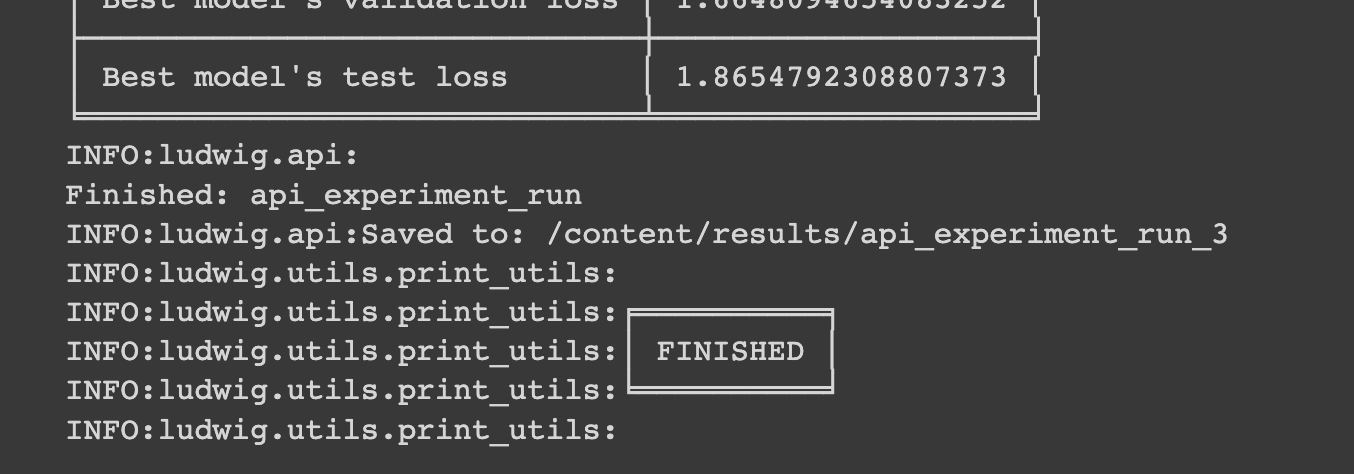

#### Want to try out our QLoRA fine-tuned weights that were fine-tuned on the entire dataset over 3 epochs? Check it out here on HuggingFace 🤗: https://huggingface.co/arnavgrg/codealpaca-qlora

```
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

config = PeftConfig.from_pretrained("arnavgrg/codealpaca-qlora")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")
model = PeftModel.from_pretrained(model, "arnavgrg/codealpaca-qlora")
```